
# Advanced Recommender Systems with Python
___

## Imports

In [48]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import mean_squared_error
from math import sqrt
import scipy.sparse as sp
from scipy.sparse.linalg import svds
import tensorflow as tf
from tensorflow.keras.callbacks import TensorBoard
import datetime
import mlflow
from mlflow.types.schema import Schema, ColSpec
from mlflow.models import ModelSignature
import os
import warnings
import matplotlib.pyplot as plt
warnings.filterwarnings('ignore')

## Load Data

### [MovieLens100K](https://files.grouplens.org/datasets/movielens/ml-100k-README.txt)

#### `u.data:` dataset containing user interactions with items that identifies movies.
**Columns** 

- `user_id:` A unique identifier for each user.

- `item_id:` A unique identifier for each item (a movie, in this case).

- `rating:` The rating given by the user to the item. It is usually on a scale (e.g., 1 to 5).

- `timestamp:` The timestamp indicating when the rating was given.

In [49]:
column_names = ['user_id', 'item_id', 'rating', 'timestamp']
df = pd.read_csv('~/datafabric/assets/movies/u.data', sep='\t', names=column_names)

In [50]:
df.head()

,user_id,item_id,rating,timestamp
0,0,50,5,881250949
1,0,172,5,881250949
2,0,133,1,881250949
3,196,242,3,881250949
4,186,302,3,891717742


**Note we only have the item_id, not the movie name. We can use the `Movie_ID_Titles.data` file to grab the movie names and merge into a unique DataFrame:**

#### `Movie_Id_Titles:` dataset containing movie titles corresponding to the item IDs in the `u.data` file. 

**Columns** 

- `item_id:` A unique identifier for each movie.

- `title:` The title of the movie, including its release year.

In [51]:
movie_titles = pd.read_csv("~/datafabric/assets/movies/Movie_Id_Titles")
movie_titles.head(2)

,item_id,title
0,1,Toy Story (1995)
1,2,GoldenEye (1995)


Then merge the dataframes:

In [52]:
df = pd.merge(df,movie_titles,on='item_id')

##### Final DataFrame

In [53]:
display(df.sample(2))
display(df.shape)

,user_id,item_id,rating,timestamp,title
44798,667,318,5,891034976,Schindler's List (1993)
45703,589,300,5,883352600,Air Force One (1997)


(100003, 5)

Now, we have a total of 100003 rows and 5 columns in our DataFrame. Let's explore it! 😎

## Exploratory Data Analysis 📊

In [54]:
n_users = df.user_id.nunique()
n_items = df.item_id.nunique()

print(f'The dataset contains {n_users} users and {n_items} different movies.')

The dataset contains 944 users and 1682 different movies.


#### Rating

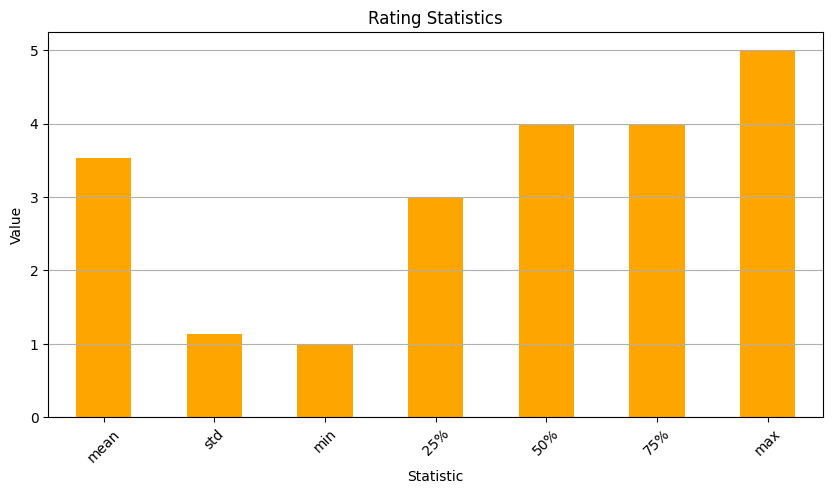

In [55]:
rating_stats = df['rating'].describe().drop('count')
plt.figure(figsize=(10, 5))
rating_stats.plot(kind='bar', color='orange')
plt.title('Rating Statistics')
plt.xlabel('Statistic')
plt.ylabel('Value')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

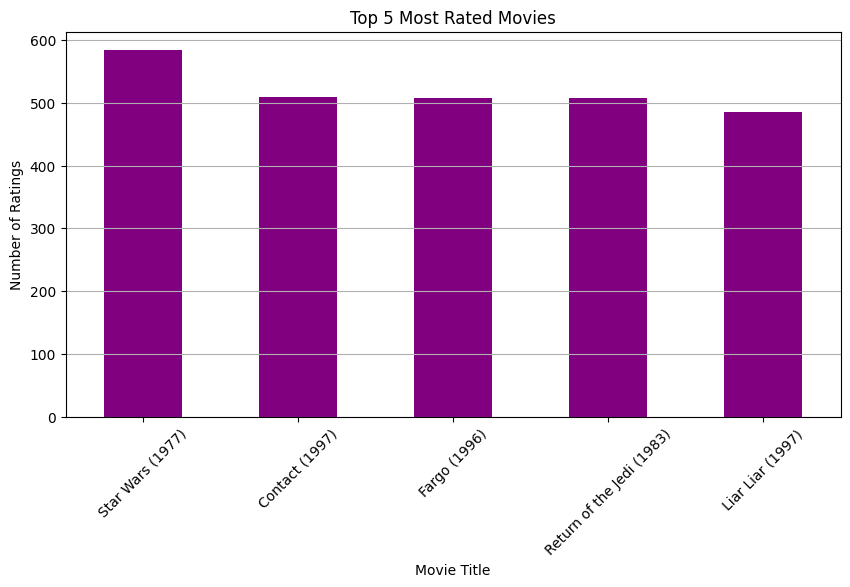

In [58]:
movie_ratings_count = df.groupby('title')['rating'].count().sort_values(ascending=False)
top_5_movies = movie_ratings_count.head(5)


plt.figure(figsize=(10, 5))
top_5_movies.plot(kind='bar', color='purple')
plt.title('Top 5 Most Rated Movies')
plt.xlabel('Movie Title')
plt.ylabel('Number of Ratings')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

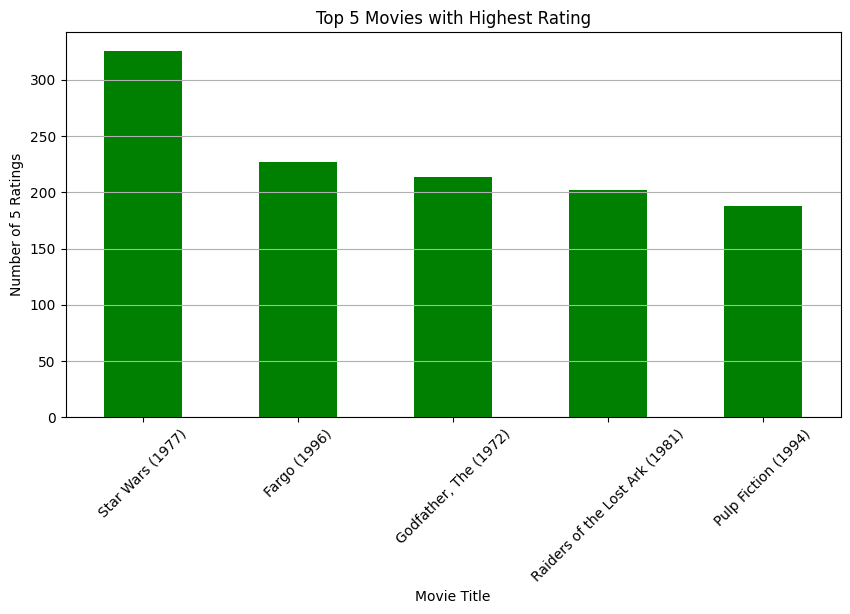

In [67]:
df_5_ratings = df[df['rating'] == 5]
movies_5_ratings = df_5_ratings.groupby('title')['rating'].count().sort_values(ascending=False).head(5)

plt.figure(figsize=(10, 5))
movies_5_ratings.plot(kind='bar', color='green')
plt.title('Top 5 Movies with Highest Rating')
plt.xlabel('Movie Title')
plt.ylabel('Number of 5 Ratings')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()

## Modeling using Memory-Based Collaborative Filtering

### What is Collaborative Filtering?
Collaborative filtering is a method used to predict what a user might like by collecting preferences from many users. The basic idea is that if users agree in the past, they will agree in the future.


### Memory-Based Collaborative Filtering
In memory-based collaborative filtering, the algorithm makes predictions based on the entire user-item dataset stored in memory. It directly uses the historical data to find patterns.

In our recommendation system experiment, we are evaluating the performance of three different collaborative filtering techniques: User-User Collaborative Filtering, Item-Item Collaborative Filtering, and SVD-based Collaborative Filtering.

- User-User Collaborative Filtering: We calculate the RMSE (Root Mean Square Error) for predictions made by finding users similar to the target user and using their ratings to predict new items.

- Item-Item Collaborative Filtering: We calculate the RMSE for predictions made by finding items similar to the ones the target user has liked and using those similarities to make new recommendations.

- SVD-based Collaborative Filtering: We use Singular Value Decomposition (SVD) to factorize the user-item interaction matrix and predict missing values. The RMSE of these predictions is also calculated.

### Train Test Split

Recommendation Systems by their very nature are very difficult to evaluate, but we will still show you how to evaluate them in this tutorial. In order to do this, we'll split our data into two sets. However, we won't do our classic X_train,X_test,y_train,y_test split. Instead we can actually just segement the data into two sets of data:

In [70]:
train_data, test_data = train_test_split(df, test_size=0.25)

## Memory-Based Collaborative Filtering

In [71]:
#Create two user-item matrices, one for training and another for testing
train_data_matrix = np.zeros((n_users, n_items))
for line in train_data.itertuples():
    train_data_matrix[line[1]-1, line[2]-1] = line[3]  

test_data_matrix = np.zeros((n_users, n_items))
for line in test_data.itertuples():
    test_data_matrix[line[1]-1, line[2]-1] = line[3]

You can use the [pairwise_distances](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.pairwise.pairwise_distances.html) function from sklearn to calculate the cosine similarity. Note, the output will range from 0 to 1 since the ratings are all positive.

In [72]:
user_similarity = pairwise_distances(train_data_matrix, metric='cosine')
item_similarity = pairwise_distances(train_data_matrix.T, metric='cosine')

In [73]:
def predict(ratings, similarity, type='user'):
    if type == 'user':
        mean_user_rating = ratings.mean(axis=1)
        #You use np.newaxis so that mean_user_rating has same format as ratings
        ratings_diff = (ratings - mean_user_rating[:, np.newaxis]) 
        pred = mean_user_rating[:, np.newaxis] + similarity.dot(ratings_diff) / np.array([np.abs(similarity).sum(axis=1)]).T
    elif type == 'item':
        pred = ratings.dot(similarity) / np.array([np.abs(similarity).sum(axis=1)])     
    return pred

In [74]:
item_prediction = predict(train_data_matrix, item_similarity, type='item')
user_prediction = predict(train_data_matrix, user_similarity, type='user')

### Evaluation

Since you only want to consider predicted ratings that are in the test dataset, you filter out all other elements in the prediction matrix with `prediction[ground_truth.nonzero()]`. 

In [75]:
def rmse(prediction, ground_truth):
    prediction = prediction[ground_truth.nonzero()].flatten() 
    ground_truth = ground_truth[ground_truth.nonzero()].flatten()
    return sqrt(mean_squared_error(prediction, ground_truth))

In [76]:
print('User-based CF RMSE: ' + str(rmse(user_prediction, test_data_matrix)))
print('Item-based CF RMSE: ' + str(rmse(item_prediction, test_data_matrix)))

User-based CF RMSE: 3.1361432241180753
Item-based CF RMSE: 3.4665850581928104


## Model-based Collaborative Filtering

In [80]:
sparsity=round(1.0-len(df)/float(n_users*n_items),3)
print('The sparsity level is ' +  str(sparsity*100) + '%')

The sparsity level is 93.7%


### SVD

In [81]:
#get SVD components from train matrix. Choose k.
u, s, vt = svds(train_data_matrix, k = 20)
s_diag_matrix=np.diag(s)
X_pred = np.dot(np.dot(u, s_diag_matrix), vt)
print('User-based CF MSE: ' + str(rmse(X_pred, test_data_matrix)))

User-based CF MSE: 2.7353527363343955


### Tensorboard + Mlflow

In [82]:
log_dir = "/phoenix/tensorboard/tensorlogs/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1, write_graph=True, write_images=True)

mlflow.set_experiment("MovieRecommenderExperiment")

with mlflow.start_run() as run:
    user_rmse = rmse(user_prediction, test_data_matrix)
    item_rmse = rmse(item_prediction, test_data_matrix)
    svd_rmse = rmse(X_pred, test_data_matrix)
    
    mlflow.log_metric("User_based_CF_RMSE", user_rmse)
    mlflow.log_metric("Item_based_CF_RMSE", item_rmse)
    mlflow.log_metric("User_based_CF_MSE_SVD", svd_rmse)
    
    writer = tf.summary.create_file_writer(log_dir)
    
    with writer.as_default():
        tf.summary.scalar("User_based_CF_RMSE", user_rmse, step=1)
        tf.summary.scalar("Item_based_CF_RMSE", item_rmse, step=1)
        tf.summary.scalar("User_based_CF_MSE_SVD", svd_rmse, step=1)
        writer.flush()

    mlflow.tensorflow.autolog()


2024/07/11 14:29:22 INFO mlflow.tracking.fluent: Experiment with name 'MovieRecommenderExperiment' does not exist. Creating a new experiment.
2024/07/11 14:29:23 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of tensorflow. If you encounter errors during autologging, try upgrading / downgrading tensorflow to a supported version, or try upgrading MLflow.


### MLflow + Model Service

In [85]:
def normalize_ratings(ratings, min_rating=1, max_rating=5):
    ratings = np.array(ratings)
    if ratings.max() == ratings.min():
        return np.full(ratings.shape, (max_rating + min_rating) / 2)
    normalized_ratings = (ratings - ratings.min()) / (ratings.max() - ratings.min()) * (max_rating - min_rating) + min_rating
    return np.clip(normalized_ratings, min_rating, max_rating)  

class MovieRecommender(mlflow.pyfunc.PythonModel):

    def load_context(self, context):
        self.train_data_matrix = np.load(context.artifacts["train_data_matrix"])
        self.movie_titles = pd.read_csv(context.artifacts["movie_titles_path"])
        self.n_users, self.n_items = self.train_data_matrix.shape

    def predict(self, context, model_input):
        movie_id = int(model_input['movie_id'][0])
        rating = float(model_input['rating'][0])

        user_ratings = np.zeros(self.n_items)
        user_ratings[movie_id - 1] = rating

        ratings = np.vstack([self.train_data_matrix, user_ratings])

        item_similarity = pairwise_distances(ratings.T, metric='cosine')

        mean_item_rating = ratings[:-1].mean(axis=0)  
        ratings_diff = (ratings[:-1] - mean_item_rating)
        pred = mean_item_rating + item_similarity.dot(ratings_diff.T).T[-1]

        user_pred_normalized = normalize_ratings(pred)

        movie_titles = self.movie_titles['title'].tolist()

        predictions_with_titles = list(zip(movie_titles, user_pred_normalized))

        print("Original predictions:", pred)
        print("Normalized predictions:", user_pred_normalized)

        return predictions_with_titles

    @classmethod
    def log_model(cls, train_data_matrix_path, movie_titles_path):
        input_schema = Schema([
            ColSpec("long", "movie_id"),
            ColSpec("double", "rating")
        ])
        output_schema = Schema([
            ColSpec("string", "movie_title"),
            ColSpec("double", "prediction")
        ])
        signature = ModelSignature(inputs=input_schema, outputs=output_schema)

        mlflow.pyfunc.log_model(
            artifact_path="movie_recommender_model",
            python_model=cls(),
            artifacts={
                "train_data_matrix": train_data_matrix_path,
                "movie_titles_path": movie_titles_path
            },
            signature=signature,
            pip_requirements=["mlflow", "pandas", "scikit-learn", "numpy"]
        )

output_dir = "model_artifacts"
os.makedirs(output_dir, exist_ok=True)
train_data_matrix_path = os.path.join(output_dir, "train_data_matrix.npy")
np.save(train_data_matrix_path, train_data_matrix)
movie_titles_path = os.path.join(output_dir, "movie_titles.csv")
movie_titles.to_csv(movie_titles_path, index=False)

mlflow.set_experiment("MovieRecommenderExperiment")

with mlflow.start_run() as run:
    MovieRecommender.log_model(train_data_matrix_path, movie_titles_path)
    model_uri = f"runs:/{run.info.run_id}/movie_recommender_model"
    mlflow.register_model(model_uri=model_uri, name="MovieRecommenderModel")


Registered model 'MovieRecommenderModel' already exists. Creating a new version of this model...
2024/07/11 14:40:54 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation. Model name: MovieRecommenderModel, version 2
Created version '2' of model 'MovieRecommenderModel'.
